**Time Series Forecasting Task**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

Read the data

In [3]:
dataDF = pd.read_csv('gdrive/My Drive/StanData.csv', infer_datetime_format = True)

In [4]:
dataDF.isna().sum().sum()

0

**Study the data**

In [6]:
dataDF.ItemName.unique()

array(['Item 1', 'Item 2', 'Item 3', 'Item 4', 'Item 5'], dtype=object)

In [7]:
# Separate out the data based on Item 
item1Data = dataDF.loc[dataDF['ItemName'] == 'Item 1']
item2Data = dataDF.loc[dataDF['ItemName'] == 'Item 2']
item3Data = dataDF.loc[dataDF['ItemName'] == 'Item 3']
item4Data = dataDF.loc[dataDF['ItemName'] == 'Item 4']
item5Data = dataDF.loc[dataDF['ItemName'] == 'Item 5']

In [8]:
print('Number of samples of Item 1: ',len(item1Data))
print('Number of samples of Item 2: ',len(item2Data))
print('Number of samples of Item 3: ',len(item3Data))
print('Number of samples of Item 4: ',len(item4Data))
print('Number of samples of Item 5: ',len(item5Data))
print('Total number of samples: ',len(item1Data)+len(item2Data)+len(item3Data)+len(item4Data)+len(item5Data))

Number of samples of Item 1:  498
Number of samples of Item 2:  232
Number of samples of Item 3:  90
Number of samples of Item 4:  163
Number of samples of Item 5:  684
Total number of samples:  1667


**Select Item 1 data only for further processing**

In [9]:
item1Data['InvoiceDate'].unique().shape

(249,)

In [10]:
print(len(item1Data['InvoiceId'].unique()))

485


In [12]:
# Drop all other columns instead of InvoiceDate, InvoiceID and Qty
item1Data.drop(item1Data.columns.difference(['InvoiceDate','InvoiceId','Qty']), 1, inplace=True)
item1Data.head(10)

<ipython-input-12-7327888c4aa6>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  item1Data.drop(item1Data.columns.difference(['InvoiceDate','InvoiceId','Qty']), 1, inplace=True)


,InvoiceDate,InvoiceId,Qty
0,02-06-2018,DD-1819/173,2.0
1,02-06-2018,DD-1819/167,150.0
4,04-06-2018,SGE-1819/2238,1.0
6,05-06-2018,SGE-1819/2271,2.0
7,06-06-2018,SGE-1819/2285,61.0
8,07-06-2018,SGE-1819/2297,24.0
9,07-06-2018,SGE-1819/2300,1.0
46,19-06-2018,DD-1819/199,40.0
48,19-06-2018,SGE-1819/2737,5.0
54,19-06-2018,SGE-1819/2729,25.0


There are rows where the InvoiceIds are same but Qtys are different. We add these up since they correspond to the same InvoiceID

In [14]:
idMergedDF = item1Data.groupby('InvoiceId').agg({'Qty': 'sum', 'InvoiceDate': lambda x: ', '.join(set(x))})
idMergedDF.describe()

,Qty
count,485.000000
mean,28.525773
std,50.046939
min,-182.000000
25%,5.000000
50%,15.000000
75%,34.000000
max,484.000000


In [18]:
print(idMergedDF.columns)

Index(['Qty', 'InvoiceDate'], dtype='object')


Next, since we are only dealing with Item1, we add up all the Qtys for a particular date.

In [19]:
dateMergedDF = idMergedDF.groupby('InvoiceDate')['Qty'].sum().reset_index()
dateMergedDF.describe()

,Qty
count,249.000000
mean,55.562249
std,97.198485
min,-182.000000
25%,7.000000
50%,25.000000
75%,70.000000
max,769.000000


If there are still negative Qtys remaining in our data, then we delete such rows, as they correspond to cancellation/refund of the Invoice

In [20]:
rslt_df = dateMergedDF[dateMergedDF['Qty'] < 0]

In [21]:
rslt_df.head()

,InvoiceDate,Qty
50,12-01-2019,-100.0
94,17-05-2019,-125.0
213,28-08-2018,-182.0
225,29-11-2018,-15.0


In [22]:
indexNames = dateMergedDF[ dateMergedDF['Qty'] < 0 ].index
# Delete these row indexes from dataFrame
dateMergedDF.drop(indexNames , inplace=True)

In [23]:
dateMergedDF.describe()

,Qty
count,245.000000
mean,58.191837
std,95.451472
min,1.000000
25%,9.000000
50%,25.000000
75%,71.000000
max,769.000000


In [24]:
# dateMergedDF.head(5)

In [25]:
dateMergedDF.columns

Index(['InvoiceDate', 'Qty'], dtype='object')

In [26]:
print(dateMergedDF.InvoiceDate.dtype)
dateMergedDF['InvoiceDate'] = pd.to_datetime(dateMergedDF.InvoiceDate, format="%d-%m-%Y")
print(dateMergedDF.InvoiceDate.dtype)

object
datetime64[ns]


In [27]:
dateMergedDF.head(5)

,InvoiceDate,Qty
0,2018-11-01,2.0
1,2019-01-02,5.0
2,2018-06-02,152.0
3,2018-07-03,2.0
4,2018-12-03,9.0


Since our data is sparse, we add 0 Qty valued rows to the data whenever datees are missing.

In [28]:
dateMergedDF = dateMergedDF.set_index('InvoiceDate') # Set the Date column as the index
dateMergedDF = dateMergedDF.reindex(pd.date_range(dateMergedDF.index.min(), dateMergedDF.index.max()), fill_value=0) # Reindex with a date range and fill missing values with zero
dateMergedDF['InvoiceDate'] = dateMergedDF.index # Add a new Date column with the index values
dateMergedDF = dateMergedDF.reset_index(drop=True) # Reset the index and drop the old one
dateMergedDF = dateMergedDF[['InvoiceDate', 'Qty']] # Reorder the columns to have Date first and Qty second

In [29]:
dateMergedDF.head(10)

,InvoiceDate,Qty
0,2018-06-02,152.0
1,2018-06-03,0.0
2,2018-06-04,1.0
3,2018-06-05,2.0
4,2018-06-06,61.0
5,2018-06-07,25.0
6,2018-06-08,0.0
7,2018-06-09,0.0
8,2018-06-10,0.0
9,2018-06-11,0.0


Next, we visualize our data to see if there are any visual trends in the data.

<Axes: xlabel='InvoiceDate'>

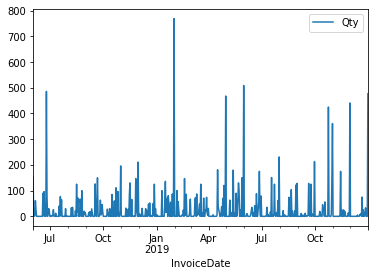

In [30]:
dateMergedDF.plot( 'InvoiceDate' , 'Qty' )

We can observe that there are a few repeating trends in the data aside from some outliers with huge Qty values. Hopefully our LSTM model will be able to capture the trend in the data.

**Day-wise Time Series Forecasting**

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [32]:
dataset = dateMergedDF['Qty'].values
dataset = dataset.astype('float32')

In [33]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1,1))

In [34]:
dataset.shape

(578, 1)

In [35]:
# split into train and test sets
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

462 116


In [36]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
 dataX, dataY = [], []
 for i in range(len(dataset)-look_back-1):
  a = dataset[i:(i+look_back), 0]
  dataX.append(a)
  dataY.append(dataset[i + look_back, 0])
 return np.array(dataX), np.array(dataY)

In [37]:
# reshape into X=t and Y=t+1
look_back = 60
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [38]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(401, 60)
(401,)
(55, 60)
(55,)


In [39]:

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(401, 60, 1)
(401,)
(55, 60, 1)
(55,)


In [41]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(256, input_shape=(look_back, 1)))
model.add(Dense(128))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=500, batch_size=8, verbose=2)

Epoch 1/500
51/51 - 8s - loss: 0.0075 - 8s/epoch - 161ms/step
Epoch 2/500
51/51 - 1s - loss: 0.0070 - 719ms/epoch - 14ms/step
Epoch 3/500
51/51 - 0s - loss: 0.0070 - 389ms/epoch - 8ms/step
Epoch 4/500
51/51 - 1s - loss: 0.0070 - 543ms/epoch - 11ms/step
Epoch 5/500
51/51 - 1s - loss: 0.0069 - 570ms/epoch - 11ms/step
Epoch 6/500
51/51 - 0s - loss: 0.0071 - 334ms/epoch - 7ms/step
Epoch 7/500
51/51 - 0s - loss: 0.0070 - 338ms/epoch - 7ms/step
Epoch 8/500
51/51 - 0s - loss: 0.0070 - 272ms/epoch - 5ms/step
Epoch 9/500
51/51 - 0s - loss: 0.0070 - 239ms/epoch - 5ms/step
Epoch 10/500
51/51 - 0s - loss: 0.0069 - 244ms/epoch - 5ms/step
Epoch 11/500
51/51 - 0s - loss: 0.0071 - 231ms/epoch - 5ms/step
Epoch 12/500
51/51 - 0s - loss: 0.0069 - 232ms/epoch - 5ms/step
Epoch 13/500
51/51 - 0s - loss: 0.0071 - 241ms/epoch - 5ms/step
Epoch 14/500
51/51 - 0s - loss: 0.0070 - 234ms/epoch - 5ms/step
Epoch 15/500
51/51 - 0s - loss: 0.0069 - 241ms/epoch - 5ms/step
Epoch 16/500
51/51 - 0s - loss: 0.0069 - 237ms/

In [42]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

2/2 [==============================] - 0s 6ms/step


In [43]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 63.71 RMSE
Test Score: 63.81 RMSE


In [61]:
# Get next prediction

def getNextPred(window):
  window = scaler.fit_transform(window.reshape(-1,1))
  window = np.reshape(window, (1, look_back, 1))
  rawPred = model.predict(window)
  scaledPred = scaler.inverse_transform(rawPred)
  return int(scaledPred[0])

In [62]:
allDataX,_ = create_dataset(dataset=dataset, look_back=60)

In [63]:
allDataX.shape

(517, 60)

In [71]:
# Get last 60 days X
window = allDataX[-1]
print(window.shape)
finalPreds = []
for i in range(90):
  nextPred = getNextPred(window)
  finalPreds.append(nextPred)
  window = window[1:]
  window = np.append(window,nextPred)

finalPreds = np.array(finalPreds)
print(finalPreds.shape)

1/1 [==============================] - 0s 19ms/step
(90,)


In [72]:
print(list(finalPreds))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


We see that a simple model converges to an all zero predicting default, because it is a decent local minima and doesn't learn any relation in our data.

**Day-wise Time Series Forecasting with Custom MSE**

In [73]:
# Define a custom loss function that doesn't consider the zero targets
def custom_mse(y_true, y_pred):
  # Create a mask for non-zero target values
  mask = tf.cast(tf.not_equal(y_true, 0), dtype=tf.float32)
  # Calculate the squared error
  sq_error = tf.square(y_pred - y_true)
  # Multiply the squared error by the mask
  masked_sq_error = mask * sq_error
  # Return the mean of the masked squared error
  return tf.reduce_mean(masked_sq_error)

In [75]:
# reshape into X=t and Y=t+1
look_back = 60
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [76]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(256, input_shape=(look_back, 1)))
model.add(Dense(128))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss=custom_mse, optimizer='adam')
model.fit(trainX, trainY, epochs=500, batch_size=8, verbose=2)

Epoch 1/500
51/51 - 3s - loss: 0.0061 - 3s/epoch - 64ms/step
Epoch 2/500
51/51 - 0s - loss: 0.0061 - 254ms/epoch - 5ms/step
Epoch 3/500
51/51 - 0s - loss: 0.0058 - 245ms/epoch - 5ms/step
Epoch 4/500
51/51 - 0s - loss: 0.0056 - 231ms/epoch - 5ms/step
Epoch 5/500
51/51 - 0s - loss: 0.0058 - 233ms/epoch - 5ms/step
Epoch 6/500
51/51 - 0s - loss: 0.0056 - 259ms/epoch - 5ms/step
Epoch 7/500
51/51 - 0s - loss: 0.0056 - 231ms/epoch - 5ms/step
Epoch 8/500
51/51 - 0s - loss: 0.0059 - 241ms/epoch - 5ms/step
Epoch 9/500
51/51 - 0s - loss: 0.0057 - 234ms/epoch - 5ms/step
Epoch 10/500
51/51 - 0s - loss: 0.0058 - 239ms/epoch - 5ms/step
Epoch 11/500
51/51 - 0s - loss: 0.0056 - 242ms/epoch - 5ms/step
Epoch 12/500
51/51 - 0s - loss: 0.0056 - 242ms/epoch - 5ms/step
Epoch 13/500
51/51 - 0s - loss: 0.0055 - 229ms/epoch - 4ms/step
Epoch 14/500
51/51 - 0s - loss: 0.0057 - 244ms/epoch - 5ms/step
Epoch 15/500
51/51 - 0s - loss: 0.0055 - 229ms/epoch - 4ms/step
Epoch 16/500
51/51 - 0s - loss: 0.0058 - 242ms/epoc

In [77]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

2/2 [==============================] - 0s 6ms/step
Train Score: 0.09 RMSE
Test Score: 0.10 RMSE


In [78]:
# Get last 60 days X
window = allDataX[-1]
print(window.shape)
finalPreds = []
for i in range(90):
  nextPred = getNextPred(window)
  finalPreds.append(nextPred)
  window = window[1:]
  window = np.append(window,nextPred)

finalPreds = np.array(finalPreds)
print(finalPreds.shape)
print(list(finalPreds))

(60,)
1/1 [==============================] - 0s 21ms/step
(90,)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


That also did not work. Next we will try to combine 10 consecutive date sum of Qty values to create our data. 

**10-days Qty-sum Based Time Series Forecasting**

In [80]:
# Define the bin edges for 10-day intervals
edges = pd.date_range(start=dateMergedDF.InvoiceDate.min(), end=dateMergedDF.InvoiceDate.max(), freq='10D')

# Group by the bin edges and calculate the sum of Qty
df_new = dateMergedDF.groupby(pd.cut(dateMergedDF.InvoiceDate, bins=edges)).agg(Qty10=('Qty', 'sum')).reset_index(drop=True)
print(df_new.head())

   Qty10
0   89.0
1  188.0
2  659.0
3   47.0
4  185.0


In [81]:
df_new.describe()

,Qty10
count,57.000000
mean,238.245614
std,180.375232
min,5.000000
25%,89.000000
50%,230.000000
75%,305.000000
max,952.000000


In [125]:
dataset10sum = df_new['Qty10'].values
dataset10sum = dataset10sum.astype('float32')

In [126]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset10sum = scaler.fit_transform(dataset10sum.reshape(-1,1))

In [127]:
# split into train and test sets
train_size = int(len(dataset10sum) * 0.8)
test_size = len(dataset10sum) - train_size
train, test = dataset10sum[0:train_size,:], dataset10sum[train_size:len(dataset10sum),:]
print(len(train), len(test))

45 12


In [128]:
# reshape into X=t and Y=t+1
look_back = 6
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [129]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(38, 6)
(38,)
(5, 6)
(5,)


In [130]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(38, 6, 1)
(38,)
(5, 6, 1)
(5,)


In [131]:
# Create an early stopping callback
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', # monitor the validation loss
    mode='min', # minimize the validation loss
    patience=300, # stop after 5 epochs with no improvement
    restore_best_weights=True # restore the best model weights after training
)

In [132]:
model = Sequential()
model.add(LSTM(256, input_shape=(look_back, 1)))
model.add(Dense(128))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss=custom_mse, optimizer='adam')
model.fit(trainX, trainY, epochs=1000, batch_size=16, validation_data=(testX, testY), callbacks=[es], verbose=2)

Epoch 1/1000
3/3 - 3s - loss: 0.0797 - val_loss: 0.0356 - 3s/epoch - 986ms/step
Epoch 2/1000
3/3 - 0s - loss: 0.0445 - val_loss: 0.0357 - 65ms/epoch - 22ms/step
Epoch 3/1000
3/3 - 0s - loss: 0.0379 - val_loss: 0.0409 - 55ms/epoch - 18ms/step
Epoch 4/1000
3/3 - 0s - loss: 0.0394 - val_loss: 0.0429 - 68ms/epoch - 23ms/step
Epoch 5/1000
3/3 - 0s - loss: 0.0391 - val_loss: 0.0388 - 82ms/epoch - 27ms/step
Epoch 6/1000
3/3 - 0s - loss: 0.0362 - val_loss: 0.0350 - 106ms/epoch - 35ms/step
Epoch 7/1000
3/3 - 0s - loss: 0.0360 - val_loss: 0.0340 - 95ms/epoch - 32ms/step
Epoch 8/1000
3/3 - 0s - loss: 0.0378 - val_loss: 0.0338 - 95ms/epoch - 32ms/step
Epoch 9/1000
3/3 - 0s - loss: 0.0367 - val_loss: 0.0353 - 94ms/epoch - 31ms/step
Epoch 10/1000
3/3 - 0s - loss: 0.0353 - val_loss: 0.0370 - 106ms/epoch - 35ms/step
Epoch 11/1000
3/3 - 0s - loss: 0.0362 - val_loss: 0.0375 - 82ms/epoch - 27ms/step
Epoch 12/1000
3/3 - 0s - loss: 0.0359 - val_loss: 0.0366 - 66ms/epoch - 22ms/step
Epoch 13/1000
3/3 - 0s -

In [133]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

1/1 [==============================] - 0s 43ms/step
Train Score: 177.53 RMSE
Test Score: 207.64 RMSE


In [134]:
# Get last 60 days X
look_back = 6
allDataX,_ = create_dataset(dataset=df_new['Qty10'].values.astype('float32').reshape(-1,1), look_back=look_back)
allDataX.shape

(50, 6)

In [135]:
window = allDataX[-1]
print(window.shape)
finalPreds = []
for i in range(9):
  nextPred = getNextPred(window)
  finalPreds.append(nextPred)
  window = window[1:]
  window = np.append(window,nextPred)

finalPreds = np.array(finalPreds)
print(finalPreds.shape)
print(list(finalPreds))

(6,)
1/1 [==============================] - 0s 43ms/step
(9,)
[209, 207, 203, 191, 189, 262, 210, 210, 210]


**So the following are the predicted quantities for Item 1 for the next 90 days, with a 10 days interval Qty summed up:**

[209, 207, 203, 191, 189, 262, 210, 210, 210]

